In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [65]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import logging
logger = logging.getLogger(__name__)


In [23]:
TRAINCSV = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
TESTCSV = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
RANDOM = 7

## Data inspections

In [3]:
df = pd.read_csv(TRAINCSV)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
#  3   LotFrontage    1201 non-null   float64
#  6   Alley          91 non-null     object 
#  25  MasVnrType     588 non-null    object 
#  26  MasVnrArea     1452 non-null   float64
#  30  BsmtQual       1423 non-null   object 
#  31  BsmtCond       1423 non-null   object 
#  32  BsmtExposure   1422 non-null   object 
#  33  BsmtFinType1   1423 non-null   object 
#  35  BsmtFinType2   1422 non-null   object 
#  42  Electrical     1459 non-null   object 
#  57  FireplaceQu    770 non-null    object 
#  58  GarageType     1379 non-null   object 
#  59  GarageYrBlt    1379 non-null   float64
#  60  GarageFinish   1379 non-null   object 
#  63  GarageQual     1379 non-null   object 
#  64  GarageCond     1379 non-null   object 
#  72  PoolQC         7 non-null      object 
#  73  Fence          281 non-null    object 
#  74  MiscFeature    54 non-null     object 
# These columns are missing values
# Mean imputation can be used when the distribution of the data is normal, and the missing values are random.
# Median imputation is appropriate when the distribution of the data is skewed

In [8]:
df.drop(['Id'], axis=1, inplace=True, errors='ignore')

## EDA

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

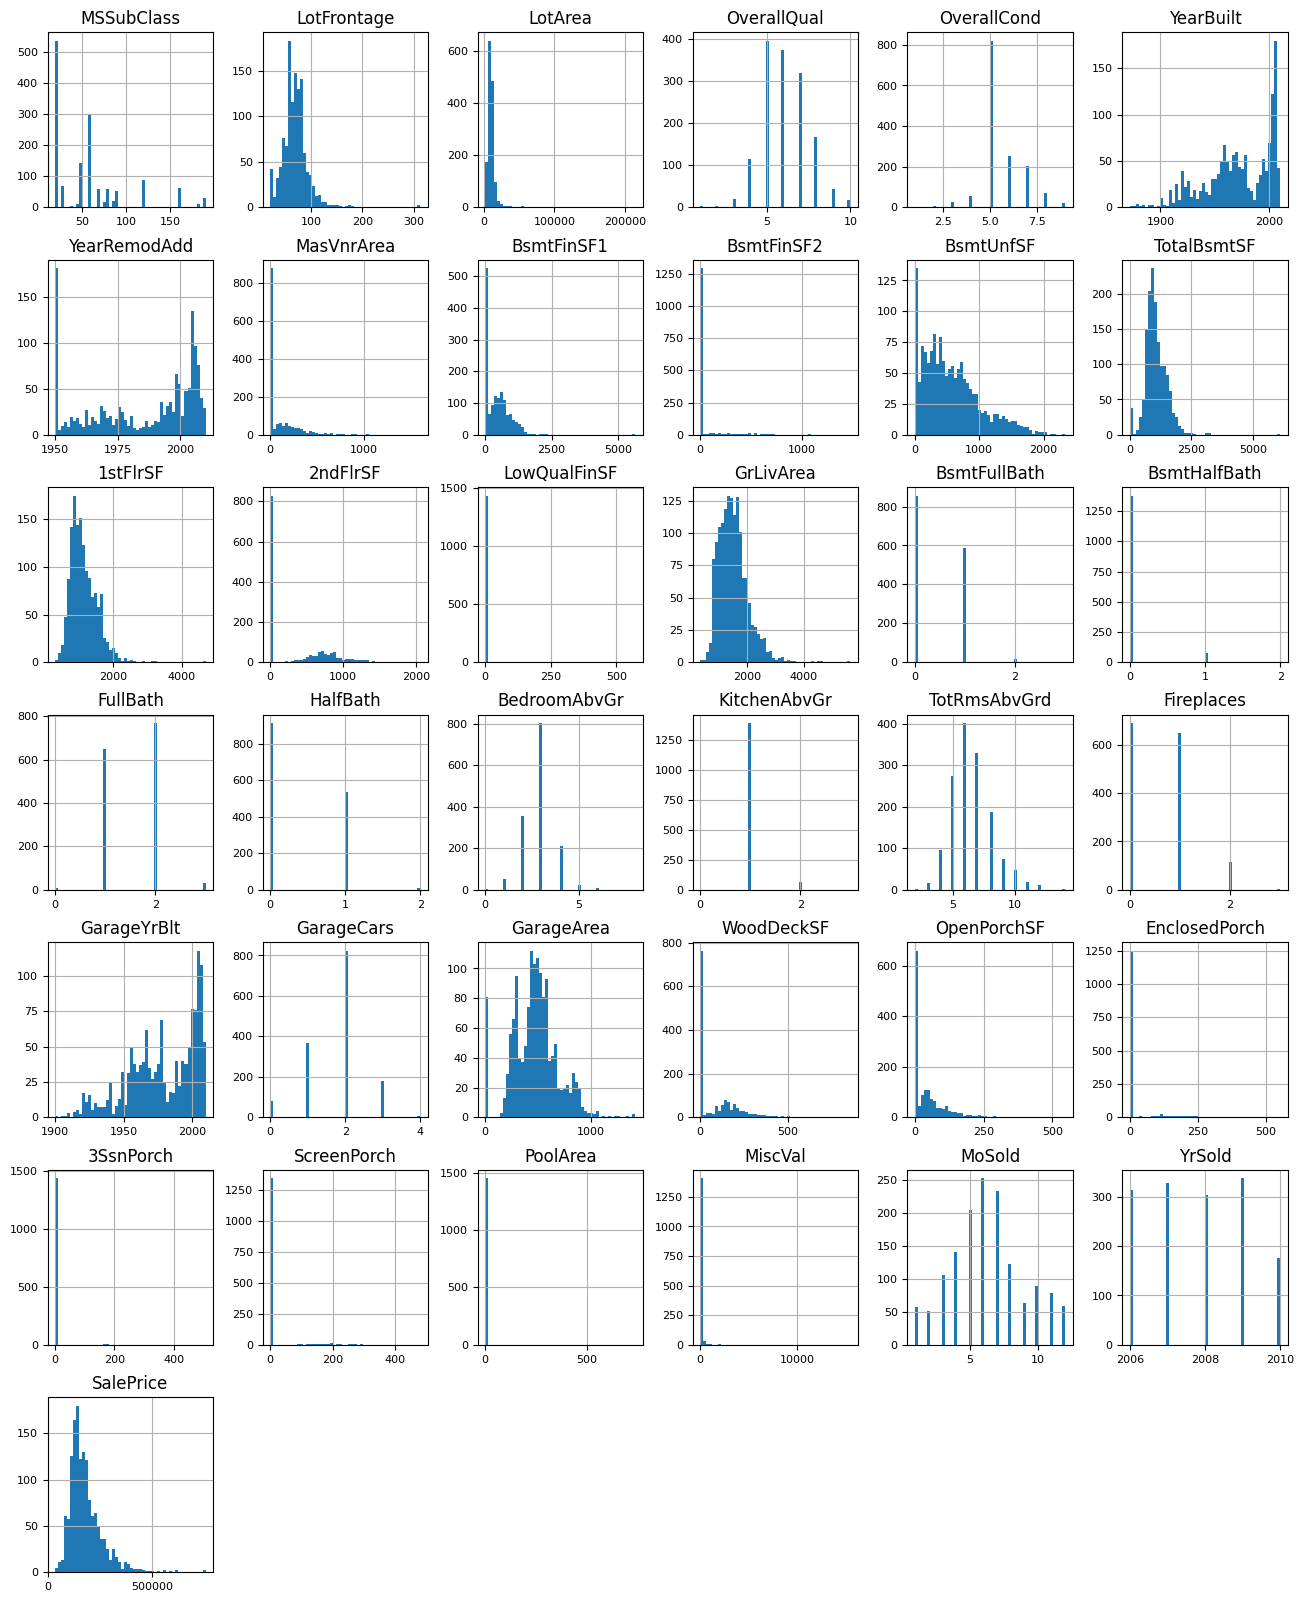

In [9]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

## Data wrangling

In [10]:
## DATA WRANGLE
#  3   LotFrontage    1201 non-null   float64 -- mean
#  6   Alley          91 non-null     object 
#  25  MasVnrType     588 non-null    object 
#  26  MasVnrArea     1452 non-null   float64 -- median
#  30  BsmtQual       1423 non-null   object 
#  31  BsmtCond       1423 non-null   object 
#  32  BsmtExposure   1422 non-null   object 
#  33  BsmtFinType1   1423 non-null   object 
#  35  BsmtFinType2   1422 non-null   object 
#  42  Electrical     1459 non-null   object 
#  57  FireplaceQu    770 non-null    object 
#  58  GarageType     1379 non-null   object 
#  59  GarageYrBlt    1379 non-null   float64 -- median
#  60  GarageFinish   1379 non-null   object 
#  63  GarageQual     1379 non-null   object 
#  64  GarageCond     1379 non-null   object 
#  72  PoolQC         7 non-null      object 
#  73  Fence          281 non-null    object 
#  74  MiscFeature    54 non-null     object 
# These columns are missing values
# Mean imputation can be used when the distribution of the data is normal, and the missing values are random.
# Median imputation is appropriate when the distribution of the data is skewed

In [12]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())

In [13]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())

In [29]:
label_encoder = LabelEncoder()

categoricals = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
for col in categoricals:
    df[col] = label_encoder.fit_transform(df[col])

## XGBoost
solely because xgboost can deal with `nan`

In [60]:
class XGBLogging(xgb.callback.TrainingCallback):
    """log train logs to file"""

    def __init__(self, epoch_log_interval=100):
        self.epoch_log_interval = epoch_log_interval

    def after_iteration(self, model, epoch, evals_log):
        if epoch % self.epoch_log_interval == 0:
            for data, metric in evals_log.items():
                metrics = list(metric.keys())
                metrics_str = ""
                for m_key in metrics:
                    metrics_str = metrics_str + f"{m_key}: {metric[m_key][-1]}"
                # TODO: why it doesn't print anything in ipython?
                logger.info(f"Epoch: {epoch}, {data}: {metrics_str}")
        # False to indicate training should not stop.
        return False


In [61]:
X, y = df.loc[:, df.columns!='SalePrice'], df.loc[:, df.columns=='SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM)

In [67]:
fixed_params = {
    "subsample": 0.5,
    "random_state": RANDOM
}
params = {
    "n_estimators": np.arange(50, 3000, 200),
    "max_depth": np.arange(2, 10),
    "learning_rate": np.linspace(0.01, 0.2, 10),
    "reg_alpha": np.linspace(0, 50)
}

rgr = xgb.XGBRegressor(**fixed_params, callbacks=[XGBLogging(epoch_log_interval=1)])

random_search = RandomizedSearchCV(estimator=rgr, param_distributions=params, n_iter=10,
                                   cv=5, scoring='neg_mean_squared_log_error', random_state=RANDOM, n_jobs=-1)

# Fit the model to the training data using RandomizedSearchCV
random_search.fit(X_train, y_train)
 
# Get the best parameters and best model
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_
 
# Make predictions on the test set using the best model
y_pred_best_random = best_model_random.predict(X_test)
 
# Evaluate the best model
mse_best_random = mean_squared_log_error(y_test, y_pred_best_random)

# Print the results
print("Best Parameters (Randomized Search):", best_params_random)
print(f"Best Model MSE log (Randomized Search): {mse_best_random}")

Best Parameters (Randomized Search): {'reg_alpha': 27.551020408163264, 'n_estimators': 1650, 'max_depth': 4, 'learning_rate': 0.052222222222222225}
Best Model MSE log (Randomized Search): 0.01633623324252858


## Submit

In [52]:
# test
df_test = pd.read_csv(TESTCSV)
# df_test
df_test_ids = df_test['Id']

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [55]:
df_test.drop(['Id'], axis=1, inplace=True, errors='ignore')

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

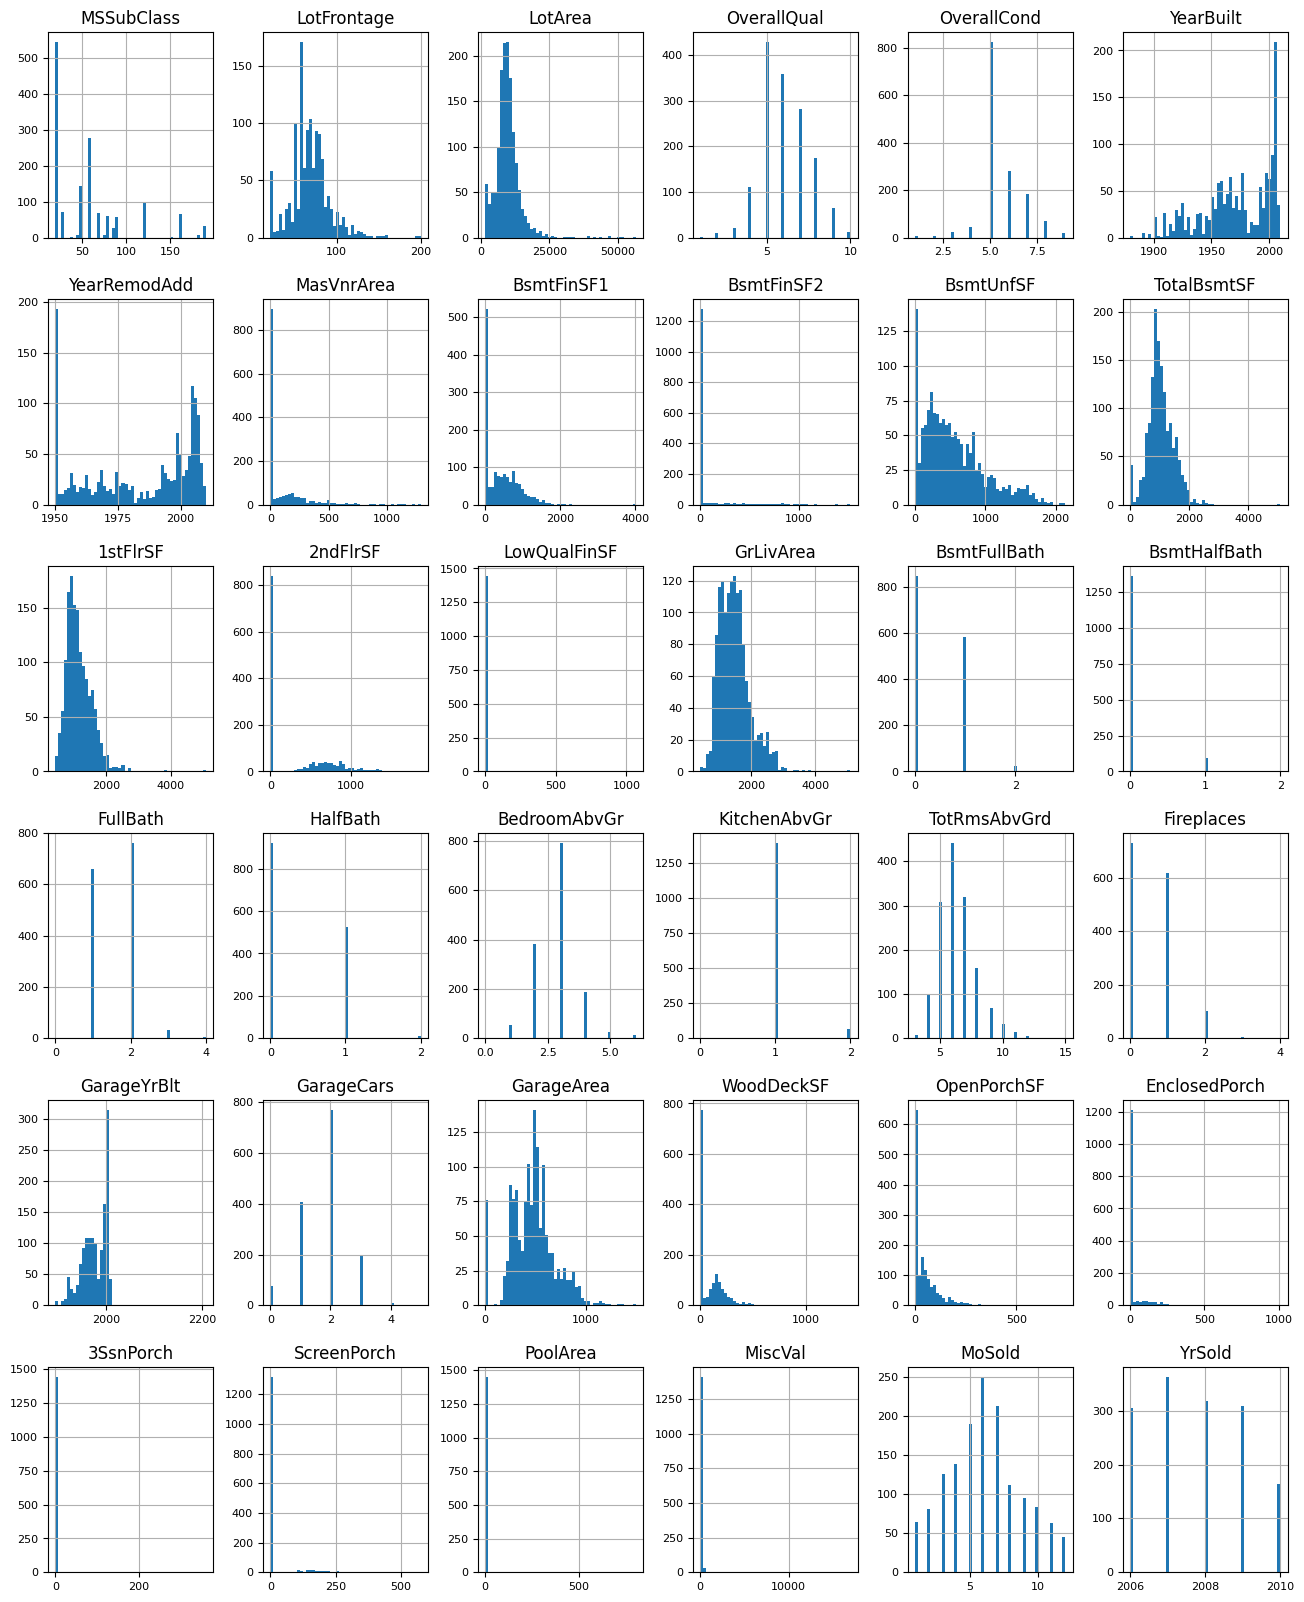

In [56]:
df_test_num = df_test.select_dtypes(include = ['float64', 'int64'])
df_test_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [ ]:
#  2   MSZoning       1455 non-null   object 
#  3   LotFrontage    1232 non-null   float64 -- mean
#  6   Alley          107 non-null    object 
#  9   Utilities      1457 non-null   object 
#  23  Exterior1st    1458 non-null   object 
#  24  Exterior2nd    1458 non-null   object 
#  25  MasVnrType     565 non-null    object 
#  26  MasVnrArea     1444 non-null   float64 -- median
#  30  BsmtQual       1415 non-null   object 
#  31  BsmtCond       1414 non-null   object 
#  32  BsmtExposure   1415 non-null   object 
#  33  BsmtFinType1   1417 non-null   object 
#  34  BsmtFinSF1     1458 non-null   float64 -- mean
#  35  BsmtFinType2   1417 non-null   object 
#  36  BsmtFinSF2     1458 non-null   float64 -- mean
#  37  BsmtUnfSF      1458 non-null   float64 -- mean
#  38  TotalBsmtSF    1458 non-null   float64 -- mean
#  47  BsmtFullBath   1457 non-null   float64 -- mean
#  48  BsmtHalfBath   1457 non-null   float64 -- mean
#  53  KitchenQual    1458 non-null   object 
#  55  Functional     1457 non-null   object 
#  57  FireplaceQu    729 non-null    object 
#  58  GarageType     1383 non-null   object 
#  59  GarageYrBlt    1381 non-null   float64 -- median
#  60  GarageFinish   1381 non-null   object 
#  61  GarageCars     1458 non-null   float64 -- mean
#  62  GarageArea     1458 non-null   float64 -- mean
#  63  GarageQual     1381 non-null   object 
#  64  GarageCond     1381 non-null   object 
#  72  PoolQC         3 non-null      object 
#  73  Fence          290 non-null    object 
#  74  MiscFeature    51 non-null     object 
#  78  SaleType       1458 non-null   object 

In [57]:
category_means = ['LotFrontage', 'BsmtFinSF1', 'BsmtFinSF2' ,'BsmtUnfSF' ,'TotalBsmtSF' ,'BsmtFullBath' ,'BsmtHalfBath' ,'GarageCars' ,'GarageArea']
category_medians = ['MasVnrArea', 'GarageYrBlt']

for cat in category_means:
    df_test[cat] = df_test[cat].fillna(df_test[cat].mean())
    
for cat in category_medians:
    df_test[cat] = df_test[cat].fillna(df_test[cat].median())

for col in categoricals:
    df_test[col] = label_encoder.fit_transform(df_test[col])

In [68]:
y_pred = best_model_random.predict(df_test)
y_pred

array([120626.06, 160162.48, 182303.66, ..., 164017.27, 124911.42,
       224836.77], dtype=float32)

In [69]:
OUTPUT = '/kaggle/working/submission.csv'
df_out = pd.DataFrame({'Id': df_test_ids, 'SalePrice': y_pred})
df_out.to_csv(f'{OUTPUT}', index=False)

In [76]:
len(best_model_random.feature_importances_)

79

In [78]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

<Axes: >

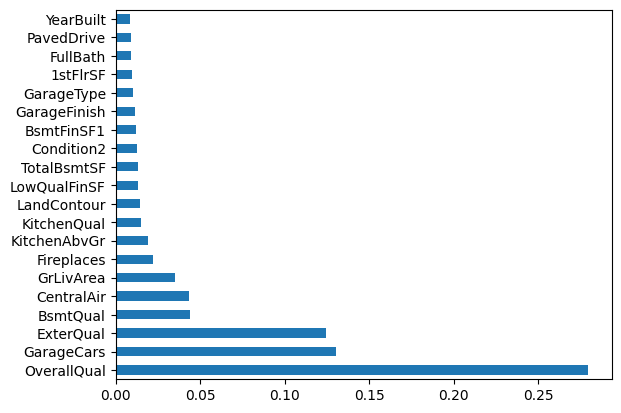

In [80]:
feat_importances = pd.Series(best_model_random.feature_importances_, index=[c for c in df.columns if c!='SalePrice'])
feat_importances.nlargest(20).plot(kind='barh')